In [1]:
# @title
!pip install shap




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 20.2 MB/s eta 0:00:00


In [2]:
import shap


In [3]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 72.8 MB/s eta 0:00:00


In [4]:
# Install necessary packages
!pip install shap rdkit scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 67.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem  # Ensure RDKit's Chem module is imported
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.isotonic import IsotonicRegression


In [6]:
# Load the dataset
glp = pd.read_csv("glp.csv")

In [7]:
# Initial data exploration
print(glp.head())
print(glp.tail())
print(glp.describe())
print(glp.shape)
print(glp.isnull().sum())

                                              Smiles  pChEMBL Value
0  CCc1cc(OC)ccc1-c1ccc(C[C@H](NC(=O)[C@H](CC(=O)...           6.01
1  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...           7.82
2  CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...           7.77
3  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...          10.26
4  CC[C@H](C)[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C...           9.85
                                                 Smiles  pChEMBL Value
1326  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...           8.05
1327  N#Cc1ccc(COc2cccc(C3CCN(Cc4nc5ccc(C(=O)O)cc5n4...           7.10
1328  Cn1c(CN2CCC(c3cccc(OCc4ccc(Cl)cc4F)n3)CC2)nc2n...           7.36
1329  Cn1c(CN2CCC(c3cccc(OCc4ccc(Cl)cc4F)n3)CC2)nc2n...           5.82
1330     C[C@H](c1c(Cl)ccc(C2CC2)c1Cl)n1cnc2cnc(Br)cc21           5.75
       pChEMBL Value
count    1331.000000
mean        8.069617
std         1.648994
min         4.000000
25%         6.750000
50%         7.930000
75%         9.64000

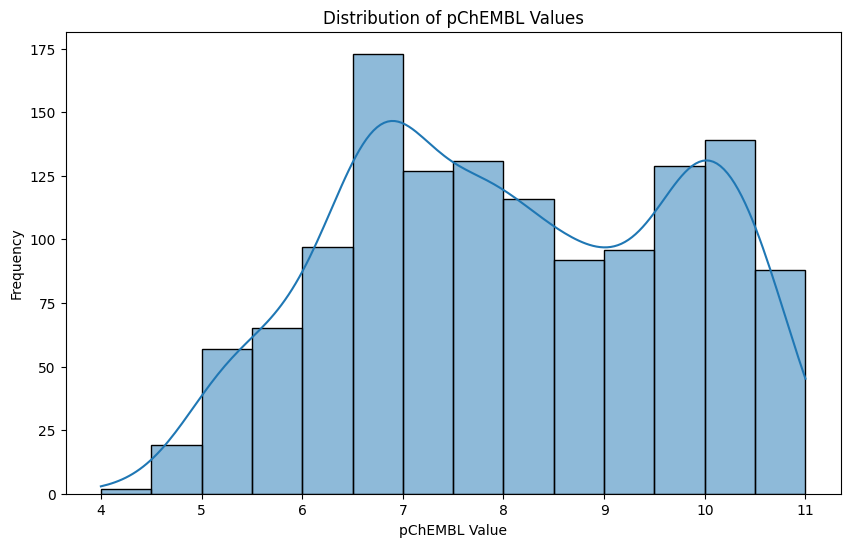

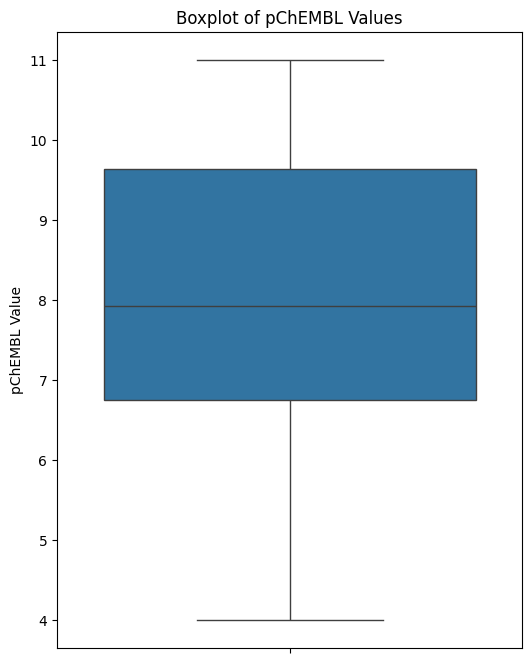

In [8]:
# Early EDA
plt.figure(figsize=(10, 6))
sns.histplot(glp['pChEMBL Value'], kde=True)
plt.title('Distribution of pChEMBL Values')
plt.xlabel('pChEMBL Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 8))
sns.boxplot(y=glp['pChEMBL Value'])
plt.title('Boxplot of pChEMBL Values')
plt.ylabel('pChEMBL Value')
plt.show()

In [9]:
# Extract SMILES and pChEMBL values
smiles = glp['Smiles']
pchembl_value = glp['pChEMBL Value']

# Function to convert SMILES to molecular fingerprints
def smiles_to_fingerprint(smiles):
    """Converts a SMILES string to a molecular fingerprint."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048)  # Handle invalid SMILES
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)
    fp = generator.GetFingerprint(mol)
    arr = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [10]:
# Apply the function to the SMILES column
X = np.array([smiles_to_fingerprint(sm) for sm in smiles])

# Define the target
y = pchembl_value

In [11]:
# Feature scaling
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

In [12]:
mlp = MLPRegressor(
    hidden_layer_sizes=(100,),  # Single hidden layer with 100 neurons
    activation='relu',          # ReLU activation function
    solver='adam',              # Adam optimizer
    alpha=0.0001,               # L2 penalty (regularization term)
    learning_rate='constant',   # Learning rate remains constant
    max_iter=500,               # Maximum number of iterations
    random_state=42             # Random state for reproducibility
)

In [13]:
param_dist = {
    'hidden_layer_sizes': [(randint.rvs(50, 150),), (randint.rvs(100, 300),), (randint.rvs(150, 500),)],  # Varying hidden layer sizes
    'activation': ['logistic', 'relu', 'tanh'],  # Different activation functions
    'solver': ['adam', 'lbfgs', 'sgd'],  # Different solvers for optimization
    'alpha': uniform(0.0001, 0.1),  # Regularization term, continuous uniform distribution
    'learning_rate': ['constant', 'adaptive', 'invscaling'],  # Learning rate schedule
    'learning_rate_init': uniform(0.0001, 0.01),  # Initial learning rate, continuous uniform distribution
    'max_iter': randint(100, 1000),  # Number of iterations for training
    'early_stopping': [True, False],  # Whether to use early stopping
}

In [14]:
# Initialize RandomizedSearchCV for MLPRegressor
random_search = RandomizedSearchCV(
    mlp, param_distributions=param_dist,
    n_iter=50,  # Number of iterations, can be increased for a more thorough search
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Verbose output to track progress
    random_state=42,  # For reproducibility
    n_jobs=-1  # Use all available cores
)


In [15]:
# Fit RandomizedSearchCV to the data
random_search.fit(X_scaled, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=MLPRegressor(max_iter=500, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['logistic', 'relu',
                                                       'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eb2ded90d30>,
                                        'early_stopping': [True, False],
                                        'hidden_layer_sizes': [(97,), (277,),
                                                               (174,)],
                                        'learning_rate': ['constant',
                                                          'adaptive',
                                                          'invscaling'],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7eb2df511ed0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eb2ded5d180>,
                                        'solver': ['adam', 'lbfgs', 'sgd']},
                   random_state=42, verbose=2)

In [16]:
# Cross-validation to evaluate the model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(random_search.best_estimator_, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {np.mean(-cv_results)}')

Cross-validated MSE: 1.0472780726613136


In [17]:
# Model evaluation
y_pred = random_search.best_estimator_.predict(X_scaled)
print(f'R^2: {r2_score(y, y_pred)}')
print(f'MSE: {mean_squared_error(y, y_pred)}')
print(f'MAE: {mean_absolute_error(y, y_pred)}')
print(f'Explained Variance: {explained_variance_score(y, y_pred)}')
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
print(f"RMSE: {rmse}")

R^2: 0.770582372438337
MSE: 0.6233594961915077
MAE: 0.5429967677997888
Explained Variance: 0.7706289271587461
RMSE: 0.7895311875990129


In [18]:
y_pred_final = y_pred

In [19]:

# Create a DataFrame to display the predictions in a tabular format
results_df = pd.DataFrame({
    'SMILES': smiles,
    'Actual pChEMBL Value': y,
    'Predicted pChEMBL Value': y_pred_final
})

# Print the table
print(results_df)

                                                 SMILES  Actual pChEMBL Value  \
0     CCc1cc(OC)ccc1-c1ccc(C[C@H](NC(=O)[C@H](CC(=O)...                  6.01   
1     CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...                  7.82   
2     CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...                  7.77   
3     CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...                 10.26   
4     CC[C@H](C)[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C...                  9.85   
...                                                 ...                   ...   
1326  CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...                  8.05   
1327  N#Cc1ccc(COc2cccc(C3CCN(Cc4nc5ccc(C(=O)O)cc5n4...                  7.10   
1328  Cn1c(CN2CCC(c3cccc(OCc4ccc(Cl)cc4F)n3)CC2)nc2n...                  7.36   
1329  Cn1c(CN2CCC(c3cccc(OCc4ccc(Cl)cc4F)n3)CC2)nc2n...                  5.82   
1330     C[C@H](c1c(Cl)ccc(C2CC2)c1Cl)n1cnc2cnc(Br)cc21                  5.75   

      Predicted pChEMBL Val

In [20]:
 #save the table to a CSV file
results_df.to_csv('prediction_table.csv', index=False)
results_df.head()

,SMILES,Actual pChEMBL Value,Predicted pChEMBL Value
0,CCc1cc(OC)ccc1-c1ccc(C[C@H](NC(=O)[C@H](CC(=O)...,6.01,6.323871
1,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,7.82,6.695760
2,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,7.77,8.227662
3,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,10.26,10.089745
4,CC[C@H](C)[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C...,9.85,9.693837


In [21]:
# Calculate permutation feature importance
result = permutation_importance(random_search.best_estimator_, X_scaled, y, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

#the feature importance
feature_importances = result.importances_mean


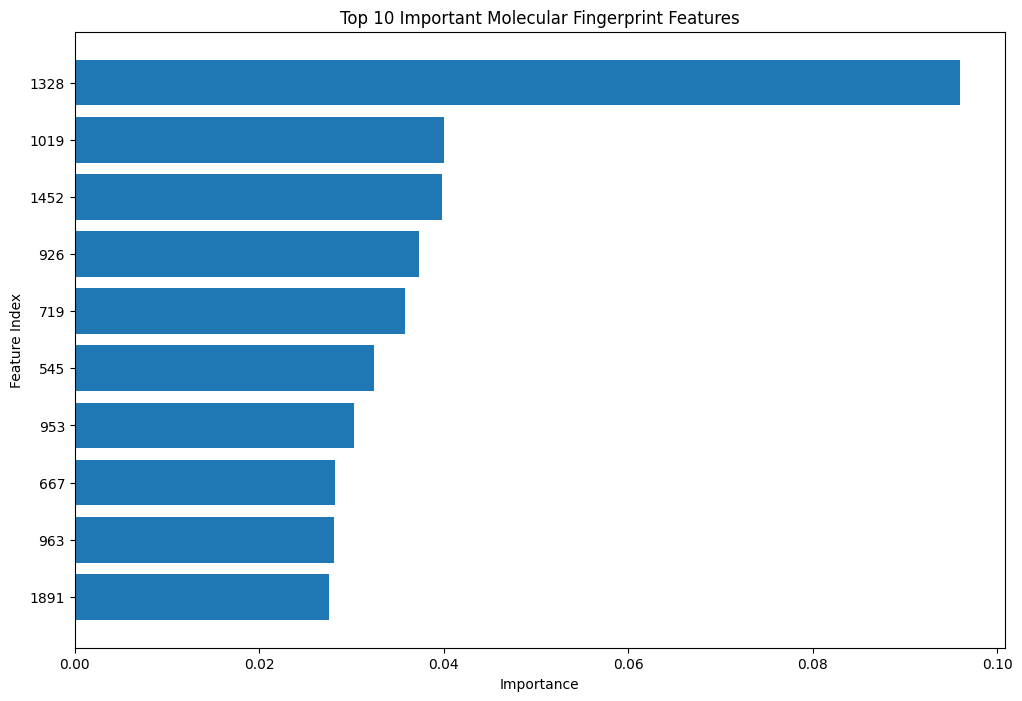

In [22]:
# Plot the top N important features for a clearer view
top_n = 10  # This can change this number to display more or fewer top features
sorted_indices = np.argsort(feature_importances)[-top_n:]
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), feature_importances[sorted_indices], align='center')
plt.yticks(range(top_n), sorted_indices)
plt.title(f'Top {top_n} Important Molecular Fingerprint Features')
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.show()

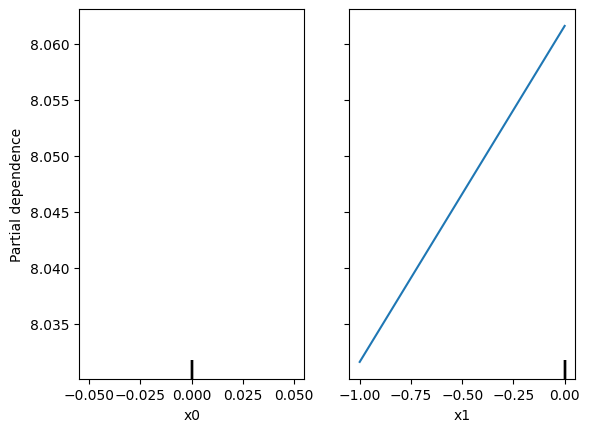

In [23]:

# Generate partial dependence plots for specific features using the fitted model
PartialDependenceDisplay.from_estimator(random_search.best_estimator_, X_scaled, features=[0, 1])
plt.show()


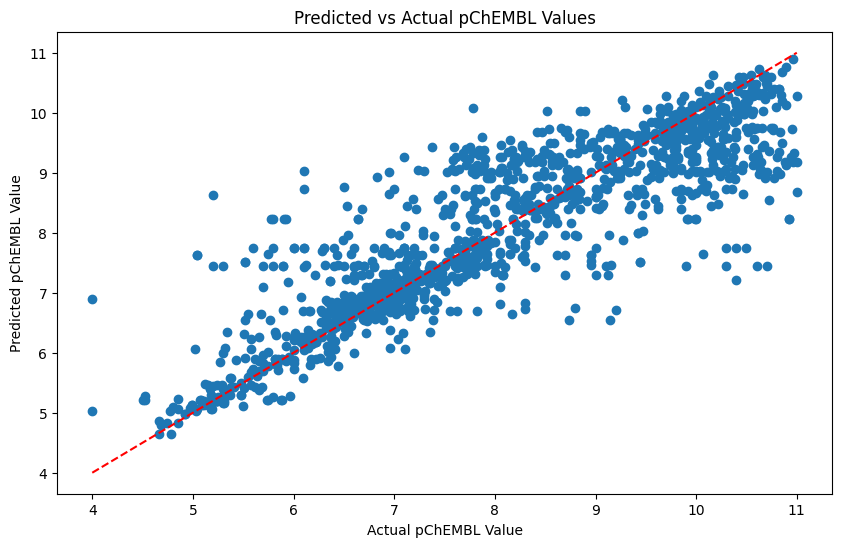

In [24]:
# Predicted vs Actual plot
y_pred = random_search.best_estimator_.predict(X_scaled)
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--') # Diagonal line for reference
plt.title('Predicted vs Actual pChEMBL Values')
plt.xlabel('Actual pChEMBL Value')
plt.ylabel('Predicted pChEMBL Value')
plt.show()



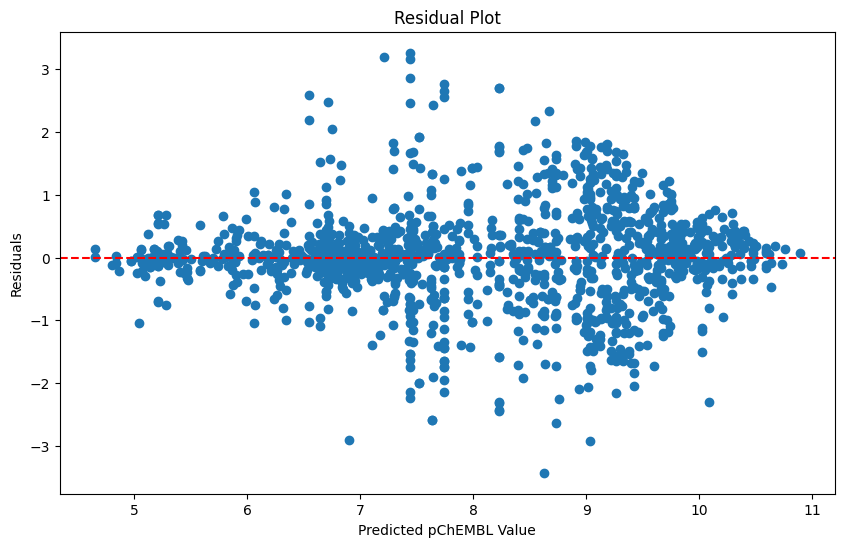

In [25]:
# Residual plot
residuals = y - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted pChEMBL Value')
plt.ylabel('Residuals')
plt.show()

In [26]:
# This saves the table to a CSV file
results_df.to_csv('predictions_table.csv', index=False)


In [27]:
### Predictions on IIR Dataset ###

# Loads the IIR dataset
iir = pd.read_csv('IIR_OCOMM_with_SMILES_filtered.csv')

In [28]:
# Extracts the SMILES column from the new dataset (IIR)
iir_smiles = iir['CanonicalSMILES']

In [29]:
# Applies the function to the SMILES column in the new dataset (IIR)
iir_fingerprints = np.array([smiles_to_fingerprint(sm) for sm in iir_smiles])


[14:14:45] WARNING: not removing hydrogen atom without neighbors


In [30]:
# This scales the fingerprints using the same scaler as before
IIR_fingerprints_scaled = scaler_X.transform(iir_fingerprints)

In [31]:
# Uses the trained model to predict pChEMBL values
IIR_predictions = random_search.best_estimator_.predict(IIR_fingerprints_scaled)


In [34]:
iir['Predicted pChEMBL Value'] = IIR_predictions

In [38]:
# SaveS the predictions to a new CSV file
iir.to_csv('IIR_OCOMM_with_SMILES_filtered_predictions.csv', index=False)
iir

,INGREDIENT_NAME,ROUTE,DOSAGE_FORM,CAS_NUMBER,UNII,POTENCY_AMOUNT,POTENCY_UNIT,CanonicalSMILES,Predicted pChEMBL Value
0,.ALPHA.-TERPINEOL,TOPICAL,LOTION,98555.0,21334LVV8W,11.00,%w/w,CC1=CCC(CC1)C(C)(C)O,6.106853
1,.ALPHA.-TOCOPHEROL,BUCCAL,"FILM, SOLUBLE",1406184.0,H4N855PNZ1,0.07,mg,CC1=C(C2=C(CCC(O2)(C)CCCC(C)CCCC(C)CCCC(C)C)C(...,6.858858
2,.ALPHA.-TOCOPHEROL ACETATE,BUCCAL,FILM,7695912.0,9E8X80D2L0,0.09,mg,CC1=C(C(=C(C2=C1OC(CC2)(C)CCCC(C)CCCC(C)CCCC(C...,6.920810
3,1-(PHENYLAZO)-2-NAPHTHYLAMINE,ORAL,CAPSULE,85847.0,3VSI4D701X,0.13,mg,C1=CC=C(C=C1)N=NC2=C(C=CC3=CC=CC=C32)N,6.917592
4,"1,2-DISTEAROYL-SN-GLYCERO-3-PHOSPHOCHOLINE",INTRAVENOUS,"INJECTABLE, LIPOSOMAL",816944.0,043IPI2M0K,2.80,%w/v,CCCCCCCCCCCCCCCCCC(=O)OCC(COP(=O)([O-])OCC[N+]...,8.102075
...,...,...,...,...,...,...,...,...,...
334,ZINC,SUBCUTANEOUS,INJECTION,7440666.0,J41CSQ7QDS,0.02,%w/v,[Zn],7.038239
335,ZINC CARBONATE,SUBCUTANEOUS,"INJECTION, POWDER, FOR SUSPENSION",5263025.0,EQR32Y7H0M,1.60,mg,C(=O)([O-])[O-].[Zn+2],6.899081
336,ZINC CHLORIDE,INTRADERMAL,INJECTION,7646857.0,86Q357L16B,7.00,mg,Cl[Zn]Cl,7.404411
337,ZINC OXIDE,INTRAVENOUS,SOLUTION,1314132.0,SOI2LOH54Z,3.11,%w/v,O=[Zn],7.355089


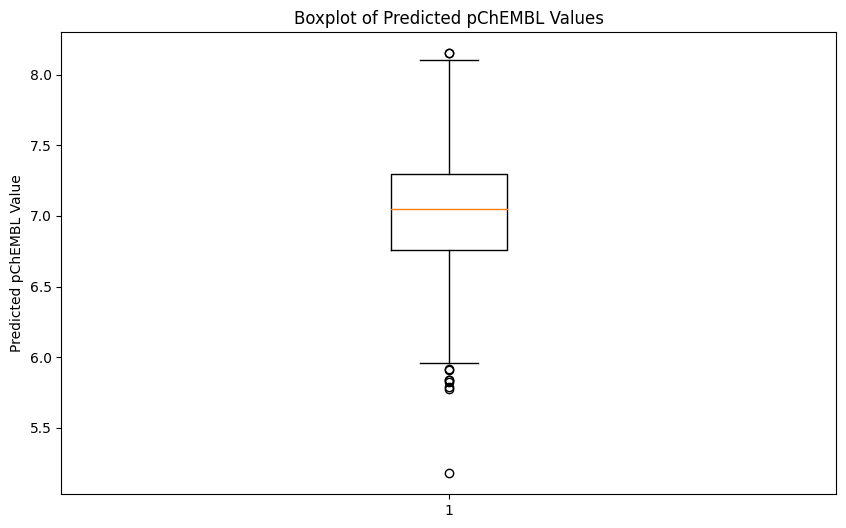

In [36]:
# Creating a boxplot for the predicted pChEMBL values
plt.figure(figsize=(10, 6))
plt.boxplot(iir['Predicted pChEMBL Value'])
plt.title('Boxplot of Predicted pChEMBL Values')
plt.ylabel('Predicted pChEMBL Value')
plt.show()

In [37]:
# Finding the top 3 key excipients with the highest predicted pChEMBL values
top_3_excipients = iir.nlargest(3, 'Predicted pChEMBL Value')[['INGREDIENT_NAME', 'Predicted pChEMBL Value']]

top_3_excipients

,INGREDIENT_NAME,Predicted pChEMBL Value
95,"DIPALMITOYLPHOSPHATIDYLGLYCEROL, DL-",8.150395
99,"DISTEAROYLPHOSPHATIDYLGLYCEROL, DL-",8.150395
4,"1,2-DISTEAROYL-SN-GLYCERO-3-PHOSPHOCHOLINE",8.102075
